# Tarea 3: PINNs, Redes Recurrentes y Transformers

En esta Tarea Trabajaremos Con [Pytorch](https://pytorch.org/), una librería de Deep Learning de código abierto desarrollada por Facebook. Pytorch es una librería de Deep Learning que se basa en el concepto de [Tensores](https://pytorch.org/docs/stable/tensors.html), que son similares a los arreglos de Numpy, pero con la diferencia de que pueden ser utilizados en una GPU para acelerar los cálculos.

Se escogio Pytorch por sobre Tensorflow o Keras ya que tiene un paquete de [diferenciacion automatica](https://pytorch.org/docs/stable/autograd.html) que nos permite calcular derivadas de forma automatica, lo que nos permite implementar de forma sencilla los modelos de redes neuronales y sobre todo trabajar con PINNs y modificar pequeños detalles de forma sencilla en el lopp de entrenamiento como lo es aplicar custom losses, etc.

Dado que la ultima seccion del curso esta enfocado a trabajar con series temporales, todos los problemas en esta tarea de alguna u otra forma estan relacionados con series temporales o secuencias.

# 1. Imports

In [1]:
#data
import numpy as np
import pandas  as pd

# torch
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(123)

En esta tarea tenemos 2 Secciones obligatorias, la parte de Redes Recurrentes y la Parte de Transformers, pero como no hay desafio Kaggle se añadio una seccion extra sobre PINNS (Physics Informed Neural Networks) la cual es opcional y sirve como bonus para la nota final.

Dado que no hay desafio Kaggle se incentiva a ser creativos y modificar los codigos, esto tambien añadira un bonus para la tarea.

# Parte 2: Redes Recurrentes

En esta tarea no hay desafio kaggle, por lo que en esta seccion deberan utilizar su creatividad para resolver un problema de series temporales, utilizando redes recurrentes.

## 2.1 Cargar Datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = 'https://raw.githubusercontent.com/AlejandroVillazonG/Tareas_INF395/main/T3/data/'
path = '/content/drive/MyDrive/INF395/'

In [4]:
train_df = pd.read_csv(path+'DailyClimate_Train.csv')
test_df = pd.read_csv(path+'DailyClimate_test.csv')

## 2.2 EDA & data Viz

En esta seccion deberan realizar un analisis exploratorio de los datos, generar visualizaciones que les permitan entender mejor los datos con los que estan trabajando y sacar conclusiones de estos.

In [5]:
train_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [6]:
train_df.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [7]:
train_df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [8]:
def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps

info = datainfo(train_df)
info.head()

,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
date,object,1462,1462,0,0.0
meantemp,float64,1462,617,0,0.0
humidity,float64,1462,897,0,0.0
wind_speed,float64,1462,730,0,0.0
meanpressure,float64,1462,626,0,0.0


In [9]:
print('Numeric variables:')
for i,variable in enumerate(train_df.select_dtypes(include = ['int64', 'float64']).columns):
    print(f'\t{i+1}. ({str(train_df[variable].dtype)}) {variable}')
print('\nCategoric variables:')
for i,variable in enumerate(train_df.select_dtypes(include = 'object').columns):
    print(f'\t{i+1}. {variable}')

Numeric variables:
	1. (float64) meantemp
	2. (float64) humidity
	3. (float64) wind_speed
	4. (float64) meanpressure

Categoric variables:
	1. date


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [11]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df.sort_values('date', inplace = True)
train_df.set_index('date', inplace=True)

test_df['date'] = pd.to_datetime(test_df['date'])
test_df = test_df.sort_values('date')
test_df.set_index('date', inplace=True)

In [12]:
train_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


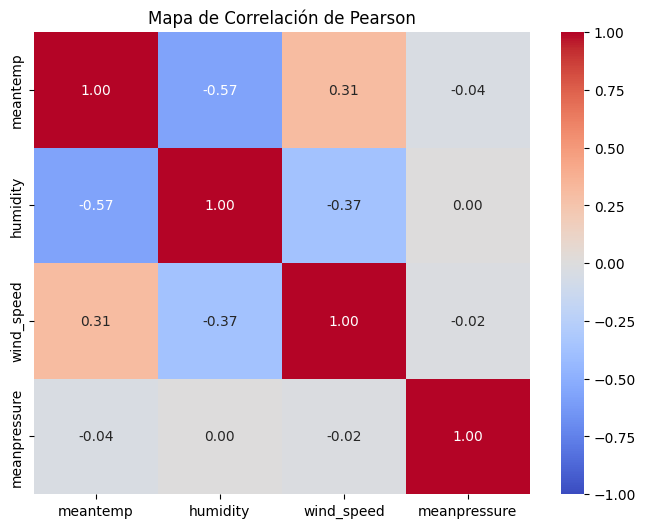

In [13]:
# Calcular la matriz de correlación de Pearson
correlation_matrix = train_df.corr()

# Crear un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Mapa de Correlación de Pearson')
plt.show()

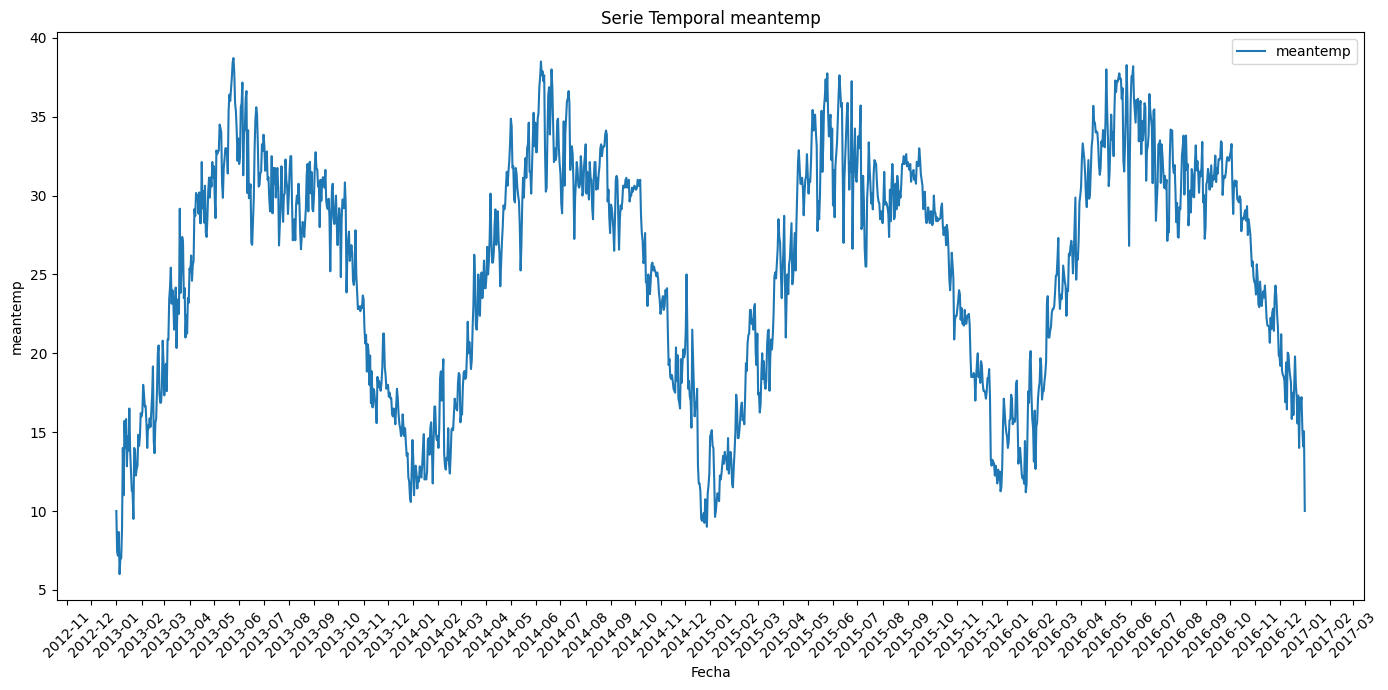

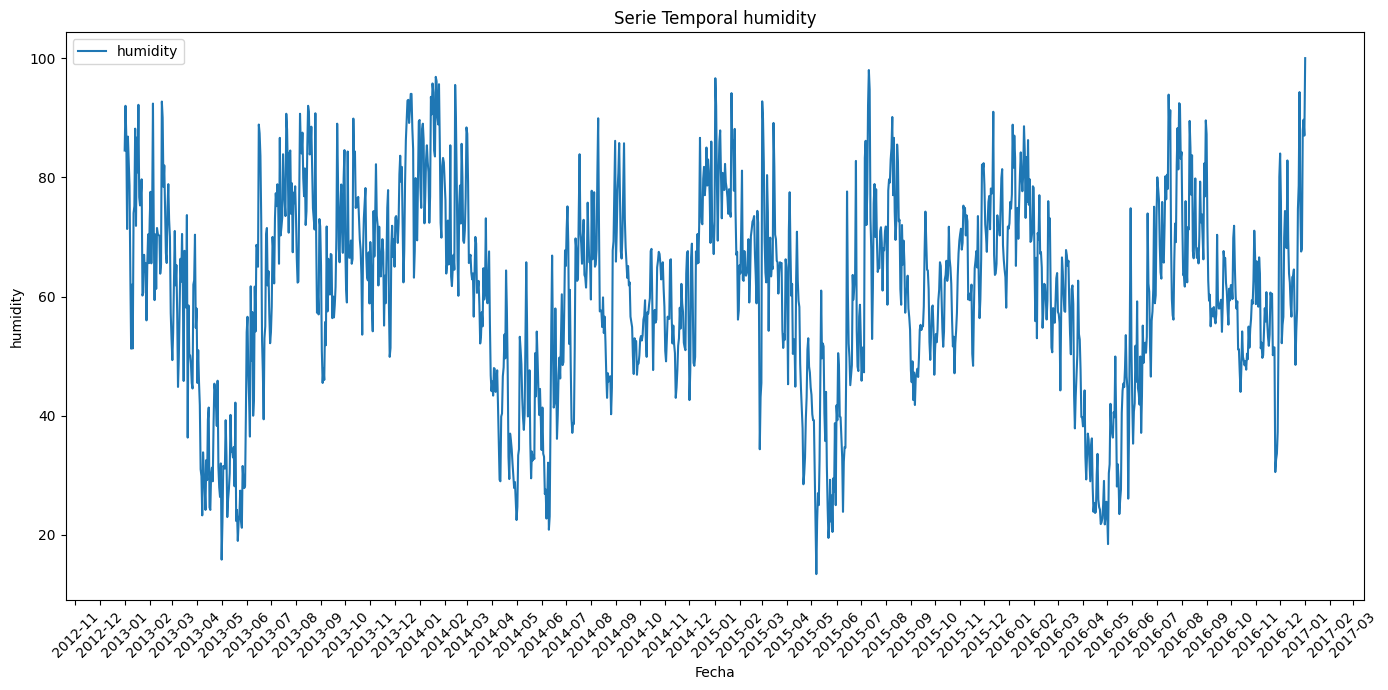

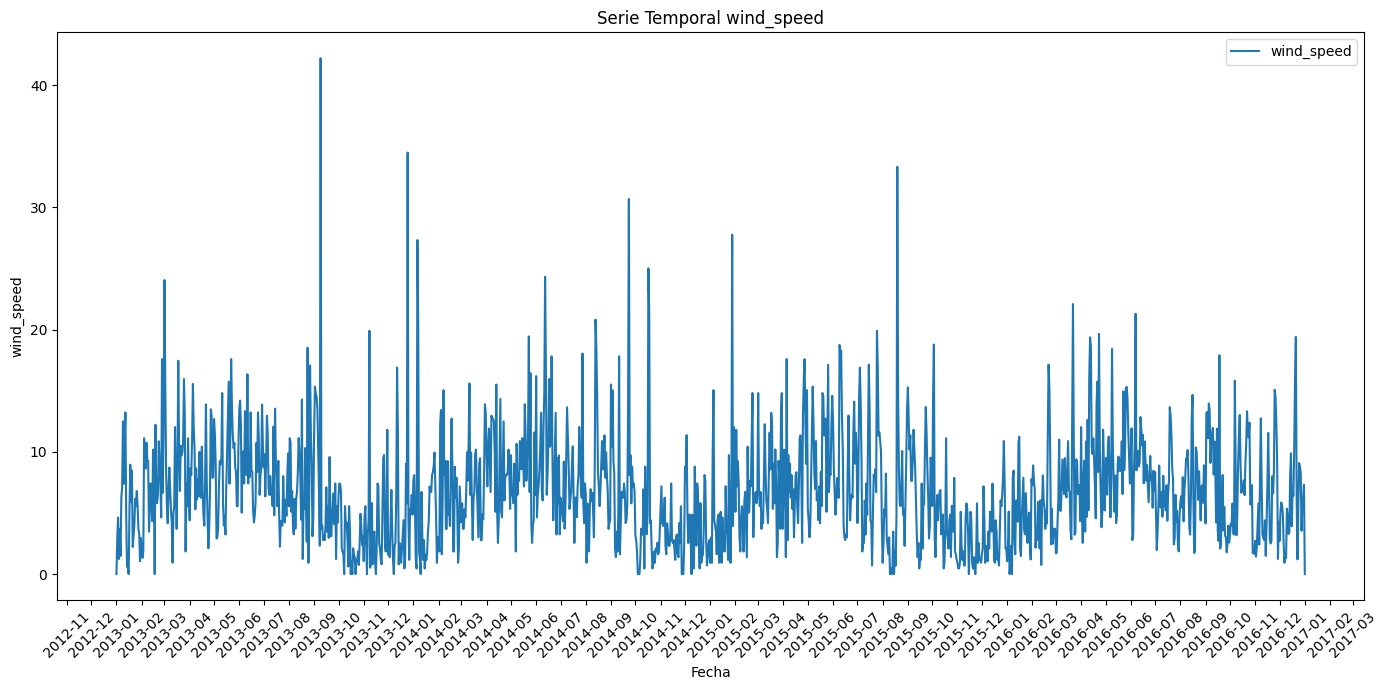

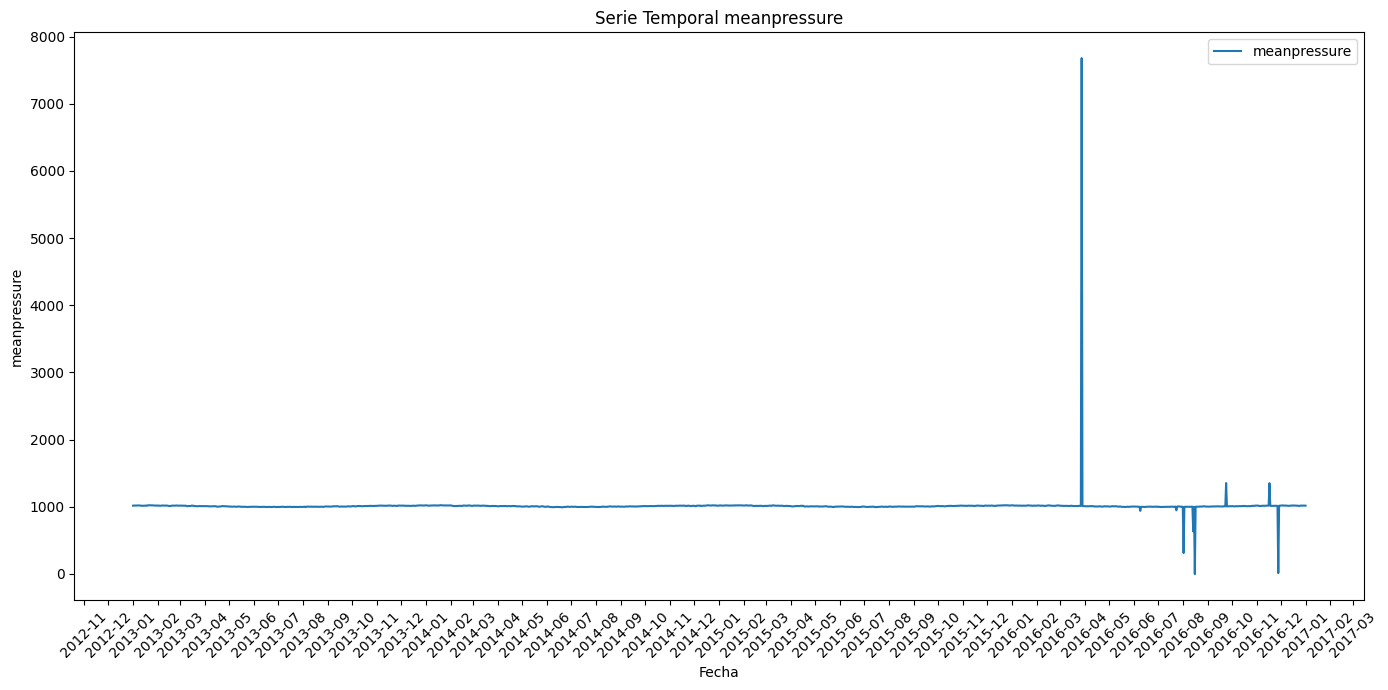

In [14]:
import matplotlib.dates as mdates

for column in train_df.columns:
  # Gráficos de series temporales
  plt.figure(figsize=(14, 7))
  plt.plot(train_df.index, train_df[column], label=column)

  # Formatear las etiquetas del eje x para mostrar solo el mes y el año
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

  # Rotar las etiquetas del eje x para mejorar la legibilidad
  plt.xticks(rotation=45)

  # Añadir título y etiquetas a los ejes
  plt.title(f'Serie Temporal {column}')
  plt.xlabel('Fecha')
  plt.ylabel(f'{column}')

  # Mostrar la leyenda
  plt.legend()

  # Ajustar layout
  plt.tight_layout()

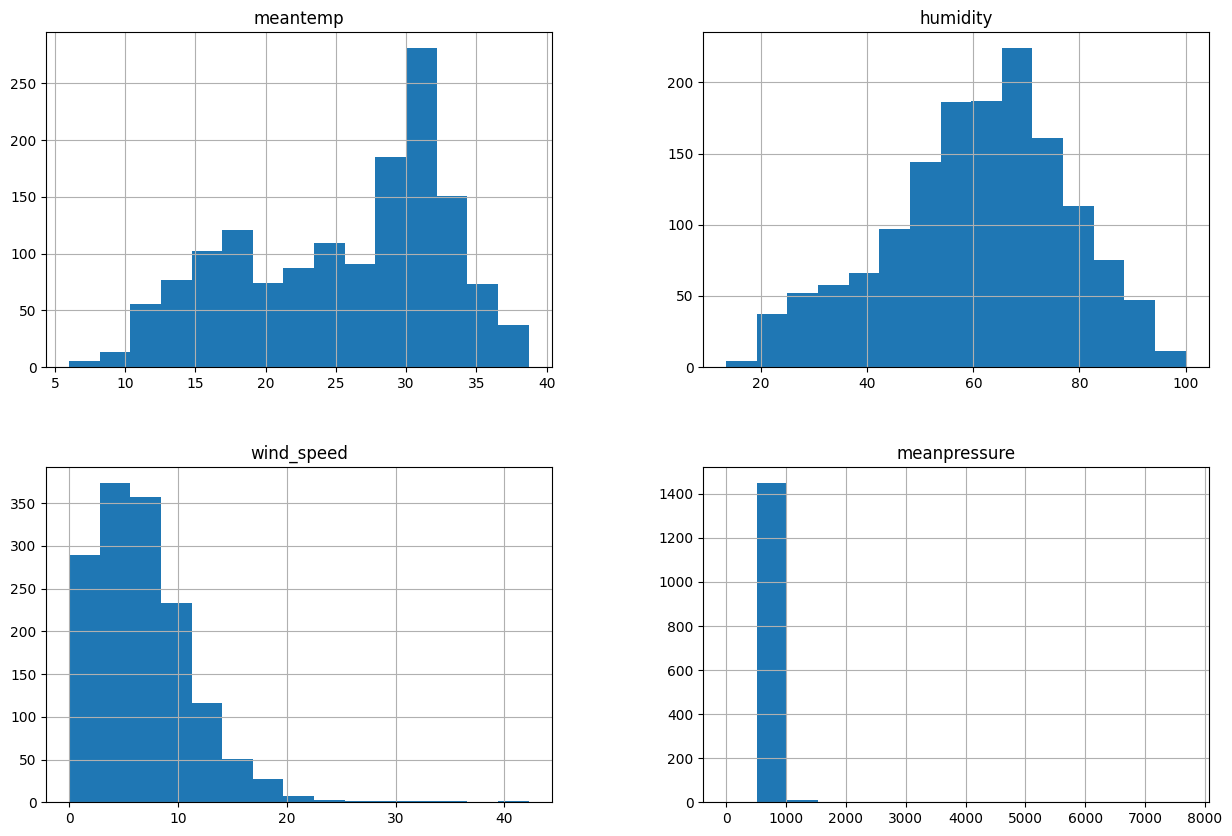

In [15]:
# Histogramas
train_df.hist(bins=15, figsize=(15, 10), layout=(2, 2))
plt.show()

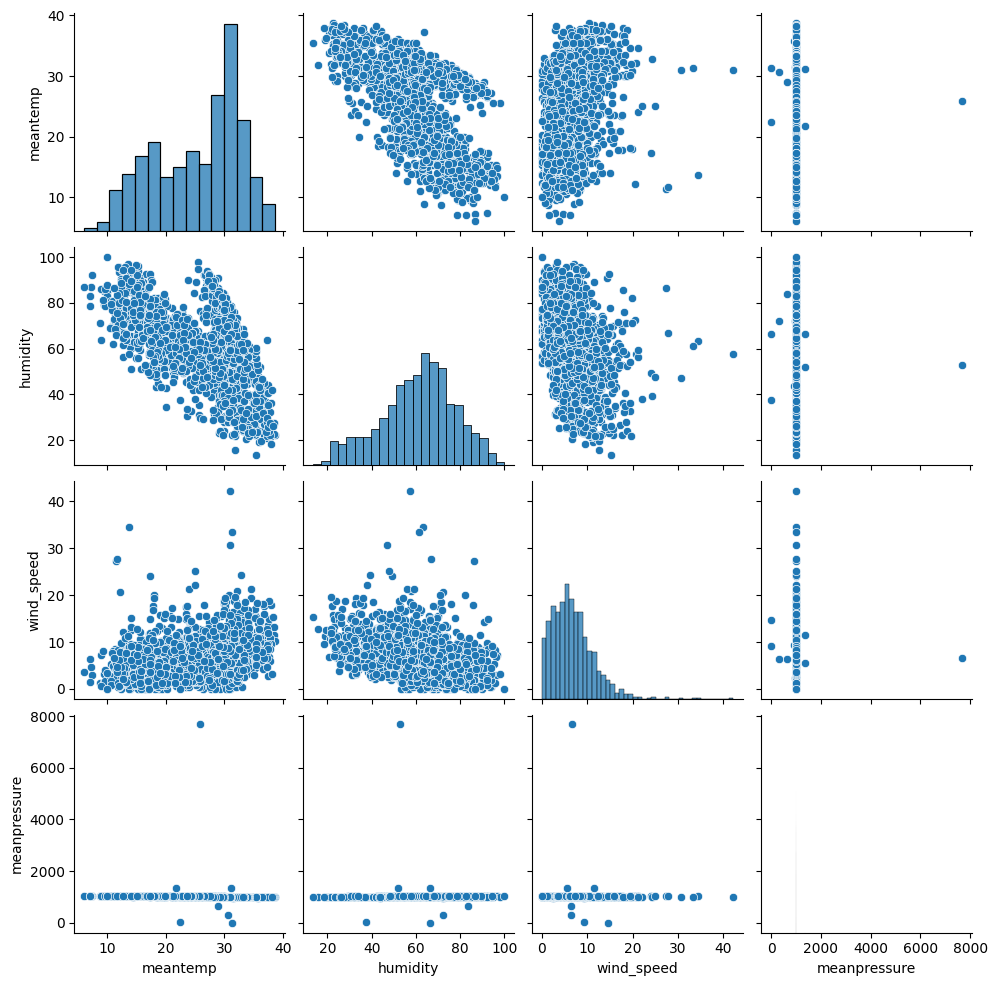

In [16]:
sns.pairplot(train_df);

## 2.3 Preprocesamiento

En esta seccion deberan aplicar las transformaciones necesarias a los datos para poder entrenar su modelo, crear columnas, eliminar columnas, escalar los datos, etc.

In [17]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

In [18]:
# Crear columnas separadas para día, mes y año
train_df['day'] = train_df.index.day
train_df['month'] = train_df.index.month
train_df['year'] = train_df.index.year

test_df['day'] = test_df.index.day
test_df['month'] = test_df.index.month
test_df['year'] = test_df.index.year

In [19]:
train_df.head()

,meantemp,humidity,wind_speed,meanpressure,day,month,year
date,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,1,1,2013
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2,1,2013
2013-01-03,7.166667,87.000000,4.633333,1018.666667,3,1,2013
2013-01-04,8.666667,71.333333,1.233333,1017.166667,4,1,2013
2013-01-05,6.000000,86.833333,3.700000,1016.500000,5,1,2013


In [20]:
train_df = preprocess_time(train_df, "day", 30)
test_df = preprocess_time(test_df, "day", 30)

train_df = preprocess_time(train_df, "month", 12)
test_df = preprocess_time(test_df, "month", 12)

In [21]:
train_df.head()

,meantemp,humidity,wind_speed,meanpressure,year,sin_day,cos_day,sin_month,cos_month
date,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,0.207912,0.978148,0.5,0.866025
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,0.406737,0.913545,0.5,0.866025
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,0.587785,0.809017,0.5,0.866025
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,0.743145,0.669131,0.5,0.866025
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,0.866025,0.500000,0.5,0.866025


In [22]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

train_df[['meantemp',	'humidity',	'wind_speed',	'meanpressure',	'year']] = standard_scaler.fit_transform(train_df[['meantemp',	'humidity',	'wind_speed',	'meanpressure',	'year']])
test_df[['meantemp',	'humidity',	'wind_speed',	'meanpressure',	'year']] = standard_scaler.transform(test_df[['meantemp',	'humidity',	'wind_speed',	'meanpressure',	'year']])

Selección de columnas

In [23]:
objective_col = 'meantemp' # columna objetivo
selected_cols = train_df.drop(columns=[objective_col]).columns.tolist()

In [24]:
# IMPORTANTE: agregamos la columna objetivo al final de la lista, deben asegurarse de que este al final para el correcto funcionamiento del codigo
selected_cols.append(objective_col)
selected_cols

['humidity',
 'wind_speed',
 'meanpressure',
 'year',
 'sin_day',
 'cos_day',
 'sin_month',
 'cos_month',
 'meantemp']

In [25]:
tr_timeseries = train_df[selected_cols].values.astype('float32')
te_timeseries = test_df[selected_cols].values.astype('float32')

In [26]:
# concatenamos los dataframes para despues hacer las visualizaciones. No borrar ni modificar
new = pd.concat([train_df, test_df], axis=0).reset_index().drop('date', axis=1)
new_timeseries = new[selected_cols].values.astype('float32')
shape = new_timeseries.shape[1]

## 2.4 Dataset y DataLoader

In [27]:
def create_dataset(dataset, lookback, shape):
    """Funcion para crear los tensores de entrenamiento y test
    dataset: np.ndarray
    lookback: int (numero de dias a considerar o largo de la secuencia)
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[:,:shape-1][i:i+lookback]
        target = dataset[:, shape-1][i:i+lookback]
        X.append(feature)
        y.append(target)
    # Convierte las listas a np.ndarray antes de convertirlas en tensores
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X), torch.tensor(y)

In [28]:
lookback = 7 # consideraremos los ultimos 7 dias para predecir el dia siguiente

train, test = tr_timeseries, te_timeseries
X_train, y_train = create_dataset(train, lookback=lookback, shape=shape)
X_test, y_test = create_dataset(test, lookback=lookback, shape=shape)

In [29]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size = 8, shuffle = True) # dataloader para entrenar los modelos de Pytorch

## 2.5 Modelo Recurrente

En esta seccion se implementa una clase base para modelos recurrentes, pueden utilizar esta clase o pueden modificarla o crear una nueva clase si lo desean, recuerden que hay bonus por creatividad en esta tarea.

In [30]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional, rnn_class):
        super().__init__()
        # Verificar que rnn_class es una de las clases de RNN permitidas
        if rnn_class not in [nn.LSTM, nn.GRU, nn.RNN]:
            raise ValueError("rnn_class must be nn.LSTM, nn.GRU, or nn.RNN")

        # Inicializar la capa recurrente con la clase pasada como parámetro
        self.rnn = rnn_class(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,
                             dropout=dropout if num_layers > 1 else 0, # El dropout se aplica solo si hay más de una capa
                             bidirectional=bidirectional)

        # Calcular la dimensión de salida de la capa recurrente
        # Es doble si es bidireccional
        factor = 2 if bidirectional else 1

        self.dropout = nn.Dropout(dropout)  # Inicializar el módulo de dropout
        self.linear1 = nn.Linear(hidden_size * factor, 64)  # Primera capa lineal después de la capa recurrente
        self.linear2 = nn.Linear(64, 10)  # Segunda capa lineal
        self.output_linear = nn.Linear(10, 1)  # Capa de salida

    def forward(self, x):
        # LSTM devuelve (output, (h_n, c_n)) mientras que GRU y RNN solo devuelve (output, h_n)
        x, _ = self.rnn(x)
        x = self.dropout(x)  # Aplicar dropout
        x = torch.relu(self.linear1(x))  # Aplicar linear1 con activación ReLU
        x = torch.relu(self.linear2(x))  # Aplicar linear2 con activación ReLU
        x = self.output_linear(x)  # Aplicar output_linear sin activación, asumiendo una tarea de regresión
        return x


## 2.6 Hiperparámetros

Aca pueden variar los hiperparametros de la red recurrente, pueden agregar mas si lo desean, para mas informacion sobre los optimizadores pueden revisar la documentacion de [pytorch Optim](https://pytorch.org/docs/stable/optim.html), y para mas informacion sobre los criterios de perdida pueden revisar la documentacion de [pytorch Loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [31]:
# Hiperparámetros del modelo
input_size = shape-1  # 'shape' debería ser el número de columnas en tus datos de entrada
hidden_size = 128  # Número de características en el estado oculto
num_layers = 2  # Número de capas recurrentes apiladas
dropout = 0.5  # Probabilidad de descartar una neurona (0 = sin dropout, 1 = todas las neuronas se descartan)
bidirectional = True  # Cambiar a False si no quieres una RNN bidireccional
layer_type = nn.RNN  # Cambiar a nn.RNN, nn.LSTM o nn.GRU según sea necesario

# Modelo
model = RNNModel(input_size, hidden_size, num_layers, dropout, bidirectional, layer_type)

# Optimizador
lr = 0.001  # Tasa de aprendizaje
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)  # Cambiar a otro optimizador si es necesario, por ejemplo, torch.optim.SGD

# Función de pérdida: MSE para regresión
loss_fn = nn.MSELoss()

## 2.7 Funciones de entrenamiento y evaluacion

En esta seccion se implementan funciones que nos ayudaran a entrenar y evaluar nuestro modelo, Pytorch no implementa metodos como .fit() por ende los tenemos que crear desde cero, al igual que antes sientanse libres de modificar o crear nuevas funciones, para mas informacion sobre el training loop pueden revisar la documentacion de [pytorch Custom Training](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#custom-training-loop)

In [32]:
class CustomEarlyStopping:
    """
    Funcion para detener el entrenamiento cuando la loss de validacion no mejora
    """
    def __init__(self, patience=20, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None

    def __call__(self, val_loss, model, X):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            self.counter = 0

In [33]:
def train_model(model, optimizer, early_stopping):
    """
    Función para entrenar el modelo.
    """
    best_score = None
    best_weights = None

    n_epochs = 200

    for epoch in range(n_epochs):
        model.train()  # Poner el modelo en modo entrenamiento
        for X_batch, y_batch in loader:
            # Forward pass: computar la predicción del modelo
            y_pred = model(X_batch)
            y_pred = y_pred.squeeze(-1)  # Esto elimina una dimensión de tamaño 1 en la última posición

            # Compute loss: calcular la pérdida entre las predicciones y los verdaderos valores
            loss = loss_fn(y_pred, y_batch)

            # Zero gradients: limpiar los gradientes antes de realizar el backward pass
            optimizer.zero_grad()

            # Backward pass: calcular el gradiente de la pérdida con respecto a los parámetros del modelo
            loss.backward()

            # Update weights: realizar un paso de optimización para actualizar los pesos
            optimizer.step()

        # Validación
        model.eval()  # Poner el modelo en modo evaluación
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train.unsqueeze(2)))

            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test.unsqueeze(2)))

            # Actualizar el mejor score y guardar los mejores pesos si se mejora el score
            if best_score is None or test_rmse < best_score:
                best_score = test_rmse
                best_weights = model.state_dict()

            # Aplicar la función de parada temprana y comprobar si se cumple el criterio de parada
            early_stopping(test_rmse, model, X_test)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Imprimir resultados cada 10 épocas
        if epoch % 10 == 0:
            print('*'*10, 'Epoch:', epoch, '\ttrain RMSE:', train_rmse, '\ttest RMSE:', test_rmse)

    return model, best_weights


In [34]:
def get_preds(model, best_weights):
    """
    Funcion para obtener las predicciones y desnormalizarlas
    """
    # Usamos los mejores pesos para hacer las predicciones
    if best_weights is not None:
        model.load_state_dict(best_weights)

        # Calculamos las predicciones
        with torch.no_grad():
            y_pred_train = model(X_train).clone().detach().cpu().numpy()
            y_pred_test = model(X_test).clone().detach().cpu().numpy()

        # Modificamos las dimensiones de las predicciones para luego graficarlas
        with torch.no_grad():
            train_predictions = np.ones_like(new_timeseries) * np.nan
            train_predictions[lookback: len(train)] = y_pred_train[:,-1,:]

            test_predictions = np.ones_like(new_timeseries) * np.nan
            test_predictions[len(train)+lookback:len(new_timeseries)] = y_pred_test[:,-1,:]

        return train_predictions, test_predictions

In [35]:
def plot_predictions(train_predictions, test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """
    # plot
    plt.figure(figsize=(20,10))
    plt.plot(new_timeseries[:,shape-1], c = 'b', label = 'True')
    plt.plot(train_predictions[:,shape-1], c='r', label = 'Train')
    plt.plot(test_predictions[:,shape-1], c='g', label = 'Test')
    plt.legend()
    plt.show()

In [36]:
def plot_eval(test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """

    eval_df = pd.concat([test_df['meantemp'].reset_index(),pd.Series(test_predictions[:,shape-1][len(train):].reshape(-1).tolist())],axis=1).drop('date',axis=1) #creamos un dataframe con las predicciones y los valores reales

    eval_df.columns = ['real_meantemp', 'pred_meantemp'] #renombramos las columnas

    rmse = np.sqrt(mean_squared_error(eval_df.iloc[7:]['real_meantemp'], eval_df.iloc[7:]['pred_meantemp'])) #calculamos el rmse

    print(f'RMSE: {rmse}')

    fig = go.Figure(data = [
        go.Scatter(x = eval_df.index, y = eval_df['real_meantemp'], mode='lines', name = "Actual"),
        go.Scatter(x = eval_df.index, y = eval_df['pred_meantemp'], mode='lines', name="Predicted"),
    ])

    fig.update_layout(
        font = dict(size=17, family="Franklin Gothic"),
        template = 'simple_white',
        title = 'Real & Predicted Temperature'
    )

    fig.show()

## 2.8 Entrenamiento

In [37]:
early_stopping = CustomEarlyStopping(patience=15, verbose=True)
model, model_best_weights = train_model(model, optimizer, early_stopping)

********** Epoch: 0 	train RMSE: tensor(0.3054) 	test RMSE: tensor(0.5180)
EarlyStopping counter: 1 out of 15, score: -0.4108550250530243
EarlyStopping counter: 2 out of 15, score: -0.4108550250530243
EarlyStopping counter: 3 out of 15, score: -0.4108550250530243
EarlyStopping counter: 4 out of 15, score: -0.4108550250530243
EarlyStopping counter: 5 out of 15, score: -0.4108550250530243
EarlyStopping counter: 6 out of 15, score: -0.4108550250530243
EarlyStopping counter: 7 out of 15, score: -0.4108550250530243
EarlyStopping counter: 1 out of 15, score: -0.40191373229026794
********** Epoch: 10 	train RMSE: tensor(0.2641) 	test RMSE: tensor(0.4701)
EarlyStopping counter: 2 out of 15, score: -0.40191373229026794
EarlyStopping counter: 3 out of 15, score: -0.40191373229026794
EarlyStopping counter: 4 out of 15, score: -0.40191373229026794
EarlyStopping counter: 5 out of 15, score: -0.40191373229026794
EarlyStopping counter: 6 out of 15, score: -0.40191373229026794
EarlyStopping counter: 7

In [38]:
train_predictions, test_predictions = get_preds(model, model_best_weights)

## 2.9 Evaluación

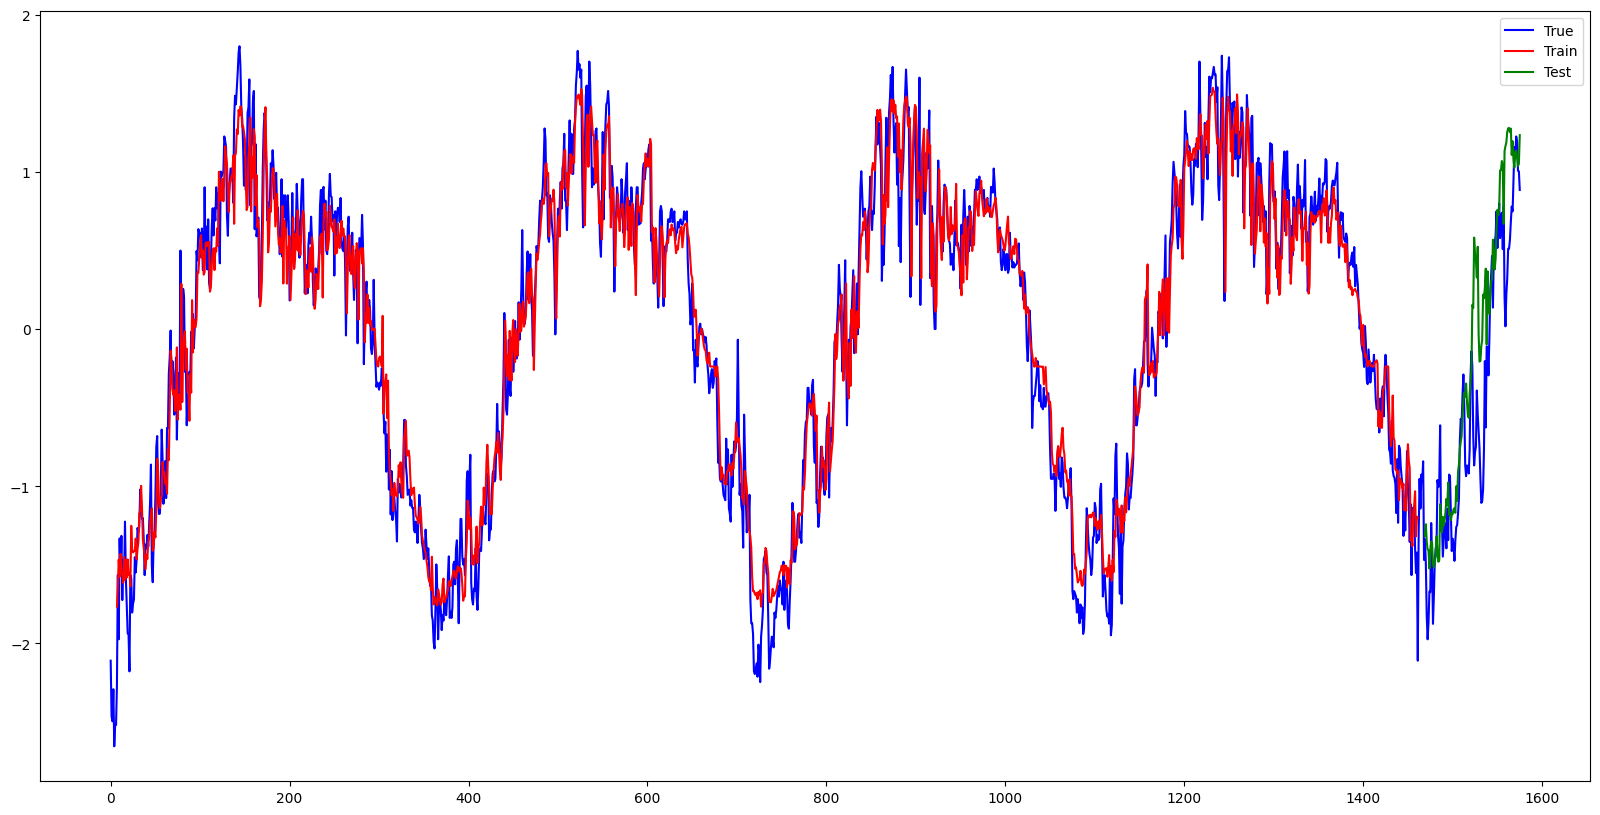

In [39]:
plot_predictions(train_predictions, test_predictions, shape)

In [40]:
plot_eval(test_predictions, shape)

RMSE: 0.4988290175781824


# Parte 3: Transformers

Para esta parte vamos a entrenar un transformer muy simple para que aprenda a generar texto como el del Quijote.

### 3.1 Cargar el dataset

In [41]:
with open(path+'el_quijote.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [42]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1038397


In [43]:
# Visualizamos los primeros 1000 caracteres
print(text[:1000])

DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, sec

### 3.2 Preprocesar el dataset

Vamos a crear un tokenizador muy simple que convierta el texto en una secuencia de números.

In [44]:
chars = sorted(set(text)) #obtener los caracteres unicos del texto
vocab_size = len(chars)
print('Caracteres unicos:',''.join(chars))
print('Largo del vocabulario:',vocab_size)

Caracteres unicos: 
 !"'(),-.0123456789:;<?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijlmnopqrstuvxyz¡«»¿̀́̃̈–‘’“”
Largo del vocabulario: 89


### 3.3 Encoding y Decoding

Ahora que tenemos el tokenizador, vamos a crear una función que nos permita convertir el texto en una secuencia de números y viceversa.

In [45]:
# Mapeamos cada caracter a un entero
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: toma un string, devuelve una lista de enteros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: toma una lista de enteros, devuelve un string

print(encode("Quijote de la Mancha"))
print(decode(encode("Quijote de la Mancha")))

[40, 71, 60, 61, 65, 70, 56, 1, 55, 56, 1, 62, 52, 1, 36, 52, 64, 54, 59, 52]
Quijote de la Mancha


**`Pregunta:`: Que otros tipos de tokenizaciones ademas de por caracteres existen y cuales serian las ventajas?**

`Respuesta:`

**`Pregunta:`: ¿que otras tecnicas se utilizan antes de tokenizar en problemas de NLP?**

`Respuesta:`

### 3.4 Train y Val Split

In [46]:
# Vamos a Codificar el texto y llevarlo a un tensor de Pytorch
data = torch.tensor(encode(text), dtype=torch.long)

# Separamos en train y validation
train_percentage = 0.8  # Utilizamos el 80% de los datos para entrenar
n = int(len(data) * train_percentage)  # Calculamos el número de datos para entrenar
train_data = data[:n]
val_data = data[n:]

print(train_data.shape, train_data.dtype)
print(train_data[:1000]) # los primeros 1000 caracteres del texto codificado


torch.Size([830717]) torch.int64
tensor([27, 38, 37,  1, 40, 44, 32, 33, 38, 43, 28,  1, 27, 28,  1, 35, 24,  1,
        36, 24, 37, 26, 31, 24,  0, 36, 60, 58, 71, 56, 62,  1, 55, 56,  1, 26,
        56, 68, 72, 52, 64, 70, 56, 69,  1, 42, 52, 52, 72, 56, 55, 68, 52,  0,
         0, 39, 41, 32, 36, 28, 41, 24,  1, 39, 24, 41, 43, 28,  0, 26, 24, 39,
        32, 81, 43, 44, 35, 38,  1, 11, 20,  1, 40, 71, 56,  1, 70, 68, 52, 70,
        52,  1, 55, 56,  1, 62, 52,  1, 54, 65, 64, 55, 60, 54, 60, 65, 81, 64,
         1, 74,  1, 56, 61, 56, 68, 54, 60, 54, 60, 65,  1, 55, 56, 62,  1, 57,
        52, 63, 65, 69, 65,  1, 59, 60, 55, 52, 62, 58, 65,  1, 27,  9,  1, 40,
        71, 60, 61, 65, 70, 56,  1, 55, 56,  1, 62, 52,  1, 36, 52, 64, 54, 59,
        52,  0, 28, 64,  1, 71, 64,  1, 62, 71, 58, 52, 68,  1, 55, 56,  1, 62,
        52,  1, 36, 52, 64, 54, 59, 52,  7,  1, 55, 56,  1, 54, 71, 74, 65,  1,
        64, 65, 63, 53, 68, 56,  1, 64, 65,  1, 67, 71, 60, 56, 68, 65,  1, 52,
       

### 3.5 Generando sequencias de texto

El transformer es una arquitectura de secuencias, por lo que necesitamos generar las secuencias de texto que vamos a utilizar para entrenar el modelo.

In [47]:
batch_size = 4 # cuantas secuencias de texto vamos a procesar en paralelo
block_size = 8 # definimos el largo de nuestra sequencia

def get_batch(split):
    # generamos un batch de datos
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [48]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"cuando el input es {context} el target es: {target}")

inputs:
torch.Size([4, 8])
tensor([[81, 62,  1, 57, 71, 56, 68, 65],
        [81,  1, 56, 62,  1, 54, 52, 63],
        [64, 70, 65, 81, 64,  7,  0, 64],
        [69, 65, 81, 62, 65,  1, 67, 71]], device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[62,  1, 57, 71, 56, 68, 65, 64],
        [ 1, 56, 62,  1, 54, 52, 63, 60],
        [70, 65, 81, 64,  7,  0, 64, 60],
        [65, 81, 62, 65,  1, 67, 71, 60]], device='cuda:0')
----
cuando el input es tensor([81], device='cuda:0') el target es: 62
cuando el input es tensor([81, 62], device='cuda:0') el target es: 1
cuando el input es tensor([81, 62,  1], device='cuda:0') el target es: 57
cuando el input es tensor([81, 62,  1, 57], device='cuda:0') el target es: 71
cuando el input es tensor([81, 62,  1, 57, 71], device='cuda:0') el target es: 56
cuando el input es tensor([81, 62,  1, 57, 71, 56], device='cuda:0') el target es: 68
cuando el input es tensor([81, 62,  1, 57, 71, 56, 68], device='cuda:0') el target es: 65
cuando el input es tens

### 3.6 Creando el modelo

Vamos a crear un modelo naive que consiste en una capa de embedding, y una capa de salida que predice la siguiente palabra

In [49]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # cada token se representa como un vector de vocab_size dimensiones
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx y targets son (B, T) arrays de indices en el vocabulario
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

**`Pregunta:`: Explique que hace la funcion Generate (indicar que hace cada linea de la funcion)**

`Respuesta:`

``` python
def generate(self, idx, max_new_tokens): # Función para generar una secuencia de tokens
        for _ in range(max_new_tokens):
            logits, loss = self(idx) # Realizar predicciones para la secuencia actual
            logits = logits[:, -1, :] # Seleccionar los logits del último token en la secuencia
            probs = F.softmax(logits, dim=-1) # Convertir logits a probabilidades utilizando softmax
            idx_next = torch.multinomial(probs, num_samples=1) # Muestrear un nuevo token basado en las probabilidades
            idx = torch.cat((idx, idx_next), dim=1) # Concatenar el nuevo token a la secuencia existente
        return idx
```

In [50]:
# Hiperparametros
naive_model = BigramLanguageModel(vocab_size).to(device)
optimizer = torch.optim.AdamW(naive_model.parameters(), lr=0.001)
batch_size = 64
epochs = 100

En esta seccion deberan crear un loop de entrenamiento para esto pueden revisar la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [51]:
# Entrenamiento
for i in range(epochs):
    # obtenemos un batch de datos
    X_batch, y_batch = get_batch('train')

    # Obtenemos las predicciones del modelo y la loss
    logits, loss = naive_model(X_batch, y_batch)

    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

    # Visualizamos el resultado cada 10 iteraciones
    if i % 10 == 0:
        print(f"Epoch {i} | Loss {loss.item():.4f}")


Epoch 0 | Loss 4.7676
Epoch 10 | Loss 4.6980
Epoch 20 | Loss 4.7771
Epoch 30 | Loss 4.6978
Epoch 40 | Loss 4.8012
Epoch 50 | Loss 4.6737
Epoch 60 | Loss 4.6517
Epoch 70 | Loss 4.6530
Epoch 80 | Loss 4.6586
Epoch 90 | Loss 4.6013


In [52]:
print('loss:', loss.item())
print(decode(naive_model.generate(idx = torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=100)[0].to('cpu').tolist()))

loss: 4.68474006652832

s‘‘ye4nhlq5Z)NfX< dlMCDq̃I-̀:(»xh[”QgfvBhP6 G?J̀"2:i"
FYC‘!¿̈q7«7EXAÖqqFaMzFfrM
fiR(d̃»ŨS"3KVa“–KS


Como vemos el modelo no es capaaz de generar texto coherente, para esto vamos a utilizar un transformer.

### 3.7 Transformer

El transformer es una arquitectura de secuencias que utiliza atención para poder capturar dependencias de largo plazo, en esta seccion deberan completar las lineas de codigo faltantes, para esto pueden revisar el paper originar [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) y la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [53]:
n_embd = 512  # Dimensión de los embeddings
n_head = 8    # Número de cabezas de atención
n_layer = 6   # Número de capas
dropout = 0.1 # Dropout

In [54]:
class Head(nn.Module):
    def __init__(self, head_size, block_size):
        super().__init__()
        self.key = nn.Linear(head_size, head_size)
        self.query = nn.Linear(head_size, head_size)
        self.value = nn.Linear(head_size, head_size)

        # Crear un buffer para la matriz triangular inferior para enmascarar la atención futura
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        # Capa de dropout
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, C = x.shape

        # Transformar la entrada a través de las capas lineales
        k = self.key(x)
        q = self.query(x)

        # Calcular la matriz de pesos (Afinidades)
        wei = q @ k.transpose(-2, -1) * C**-0.5  # Escalar y transponer para obtener afinidades
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # Enmascarar para ignorar la atención futura

        # Aplicar softmax y dropout para obtener los pesos normalizados
        softmax = F.softmax(wei, dim=-1)
        dropout = self.dropout(softmax)

        # Calcular la ponderación de los valores por los pesos atencionales
        v = self.value(x)
        out = dropout @ v  # Aplicar los pesos atencionales a los valores

        return out


**Pregunta: En sus propias palabras explique como funciona el mecanismo de auto-atencion**


La auto-atención en modelos de procesamiento de lenguaje natural permite que cada parte de una entrada, como una palabra en una oración, influya en la representación de las demás partes. Cada palabra se transforma en vectores de clave, consulta y valor mediante capas lineales. Luego, se calculan puntuaciones de atención mediante el producto punto de las claves y consultas, que se normalizan con softmax. Estas puntuaciones ponderan los valores para generar una salida contextualizada por toda la secuencia, facilitando la captura de relaciones y dependencias complejas y a largo plazo en el texto.

In [55]:
class MultiHeadAttention(nn.Module):
    """ Multiples cabezales de auto-atencion """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [56]:
class FeedForward(nn.Module):
    """ Capa FeedForward """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # Primera capa lineal que expande la dimensión
            nn.GELU(),                     # Función de activación (GELU es común en Transformers)
            nn.Dropout(dropout),           # Dropout para regularización
            nn.Linear(4 * n_embd, n_embd), # Segunda capa lineal que proyecta de vuelta a la dimensión original
        )

    def forward(self, x):
        return self.net(x)


In [57]:
class Block(nn.Module):
    """ Bloque de Transformer """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

**Pregunta: Que parte del transformer estamos implementando?**

 los componentes fundamentales de un bloque típico de transformer, incluyendo atención multi-cabeza, capas feed-forward, normalización de capa y conexiones residuales. Estos bloques se pueden apilar para construir un modelo completo de transformer para tareas como generación de texto, traducción automática, entre otras.

In [58]:
# Ahora definimos el modelo completo con los bloques de Transformer
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

**Bonus: Desde que salio el transformer se han publicado mejoras para esta arquitectura, si implementan alguna mejora con la referencia del paper en cuestion obtendran un bonus, se atreven?**

In [59]:
model = BigramLanguageModel()
m = model.to(device)

# Parametros del modelo
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Hiperparámetros
lr = 0.001  # Tasa de aprendizaje
optimizer = torch.optim.AdamW(m.parameters(), lr=lr)  # Optimizador AdamW
epochs = 50  # Número de épocas

eval_interval = 100
eval_iters = 200

NameError: ignored

In [60]:
# Funcion de evaluar el modelo
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [61]:
for i in range(epochs):
    # cada 100 iteraciones evaluamos el modelo
    if i % eval_interval == 0 or i == epochs - 1:
        losses = estimate_loss()
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Obtenemos un batch de datos
    X_batch, y_batch = get_batch('train')

    # Obtener las predicciones del modelo y la pérdida
    logits, loss = model(X_batch, y_batch)

    # Reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()


NameError: ignored

In [ ]:
# Generamos las predicciones
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Ahora las predicciones ya tienen un poco de sentido, podemos seguir entrenando el modelo para que genere texto más coherente y pueden utilizar el modelo cambiando el archivo de input para generar texto de otros libros o de lo que ustedes quieran.

# Bonus: Armonic Oscillator (PINN)

## Simular un oscilador armónico

Vamos a utilizar una red neuronal con física incorporada (PINN por sus siglas en inglés) para resolver problemas relacionados con el **oscilador armónico amortiguado**:

<img src="img/oscillator.gif" width="500">

Nos interesa modelar el desplazamiento de la masa en un resorte (caja verde) a lo largo del tiempo.

Este es un problema canónico de la física, donde el desplazamiento, $u(t)$, del oscilador como función del tiempo puede ser descrito por la siguiente ecuación diferencial:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

donde $ m $ es la masa del oscilador, $ \mu $ es el coeficiente de fricción y $ k $ es la constante del resorte.

Nos centraremos en resolver el problema en el estado **subamortiguado**, es decir, donde la oscilación es lentamente amortiguada por la fricción (como se muestra en la animación arriba).

Matemáticamente, esto ocurre cuando:

$$
\delta < \omega_0~,~~~~~\mathrm{donde}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Además, consideramos las siguientes condiciones iniciales del sistema:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

Para este caso particular, la solución exacta es conocida y dada por:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{con}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


### Definimos nuestra Red Neuronal

In [94]:
class simple_ffn(nn.Module):
    "Definimos una red neuronal feed forward en PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.input = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.hidden = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

*Pregunta: ¿Porque se utiliza Tanh como función de activación generalmente en las PINNs?*

La función de activación tanh es ampliamente utilizada en Redes Neuronales Físico-Informadas (PINNs) debido a sus características favorables: es suave y completamente diferenciable, facilitando el cálculo de derivadas necesario en ecuaciones diferenciales. Su rango de salida simétrico (-1, 1) ayuda en la normalización de los datos y mejora la convergencia durante el entrenamiento. Además, tanh es menos susceptible al problema de desvanecimiento de gradiente comparado con otras funciones de activación, una cualidad importante para las PINNs que a menudo requieren derivadas de alto orden. Estas características hacen de tanh una elección efectiva para modelar problemas físicos en PINNs.

###  Solucion Exacta

In [95]:
def exact_solution(d, w0, t):
    "Define la solucion analitica del problema planteado"
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

### Puntos de entrenamiento

In [96]:
# Definimos los puntos para la condicion de borde
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# Definimos los puntos del dominio del problema
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# parametros del problema
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

### Hiperparámetros y Modelo

In [99]:
epochs = 15001
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(pinn.parameters(),lr=1e-3)
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

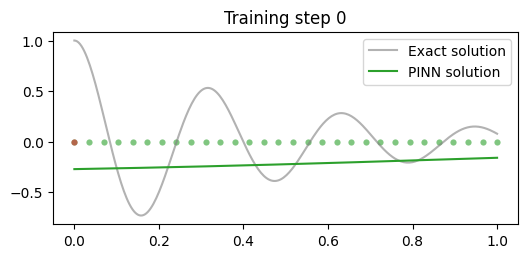

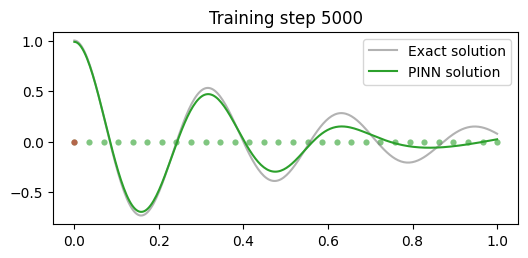

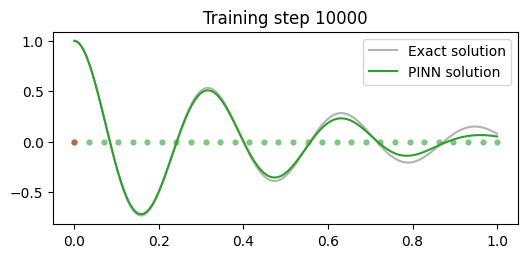

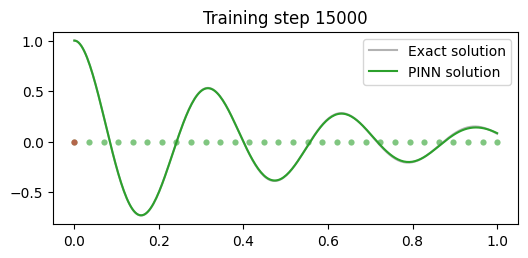

In [100]:
for i in range(15001):
    optim.zero_grad() # reseteamos el gradiente

    # Calculamos la perdida de la condicion de borde
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    loss2 = (torch.squeeze(dudt) - 0)**2

    # Calculamos la perdida de la ecuacion diferencial
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0] # calculamos la segunda derivada
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optim.step()

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

## entrenar una PINN para invertir los parámetros subyacentes

La segunda tarea consiste en usar una PINN para **Estimar** parámetros.

Específicamente, nuestras entradas y salidas son:

- Entradas: observaciones con ruido del desplazamiento del oscilador
- Salidas: estimar $\mu$, el coeficiente de fricción

#### Enfoque

De manera similar a lo anterior, la PINN se entrena para aproximar directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

donde $\theta$ son los parámetros libres de la PINN.

La idea clave aquí es también tratar $\mu$ como un **parámetro aprendible** al entrenar la PINN, de modo que simulamos la solución e invertimos para este parámetro.

#### Función de pérdida

La PINN se entrena con una función de pérdida ligeramente diferente:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

#### Notas

Hay dos términos en la función de pérdida aquí. El primero es la **pérdida física**, formada de la misma manera que arriba, que asegura que la solución aprendida por la PINN es consistente con la física conocida.

El segundo término se llama **pérdida de datos**, y asegura que la solución aprendida por la PINN se ajuste a las observaciones de la solución (potencialmente con ruido) que están disponibles.

Nota, hemos eliminado los términos de pérdida de los bordes, ya que no los conocemos (es decir, solo se nos dan las mediciones observadas del sistema).

En esta configuración, los parámetros $\theta$ y $\mu$ de la PINN se aprenden **conjuntamente** durante la optimización.

Nuevamente, la autodiferenciación es nuestra amiga y nos permitirá definir fácilmente este problema.


### Puntos de Entrenamiento

True value of mu: 4


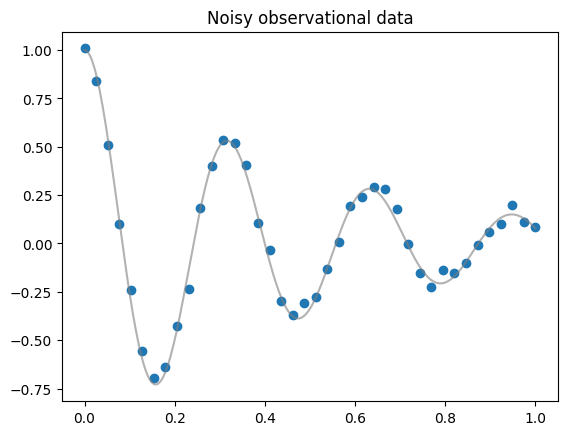

In [110]:
# Creamos data con ruido
d, w0 = 2, 20
print(f"True value of mu: {2*d}")

# Definimos los puntos observacionales
num_obs_points = 40
t_obs = torch.linspace(0, 1, num_obs_points).view(-1, 1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

# Definimos los puntos de entrenamiento sobre todo el dominio
num_physics_points = 100
t_physics = torch.linspace(0, 1, num_physics_points).view(-1, 1)
t_physics.requires_grad = True  # Asegúrate de que t_physics requiera gradiente

# Parámetros del problema
mu, k = 2*d, w0**2

# Visualización de los datos con ruido
plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()


### Hiperparámetros y Modelo

In [111]:
# Creamos un parametro entrenable para mu
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

epochs = 15_001

# Instancia el modelo PINN
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.AdamW(list(pinn.parameters())+[mu],lr=1e-3)
lambda1 = 1e4

### Entrenamiento

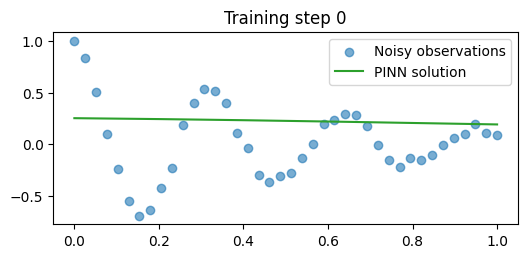

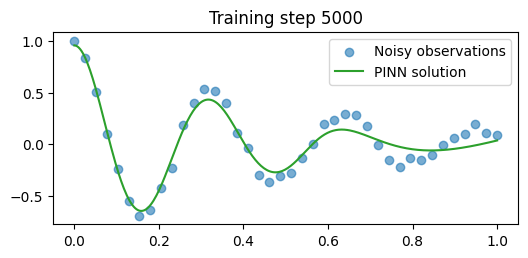

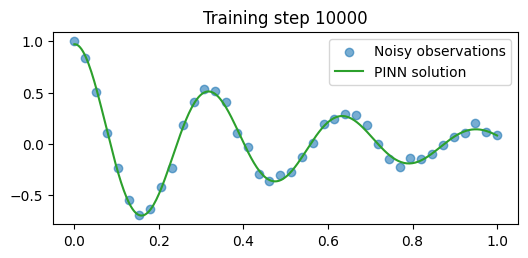

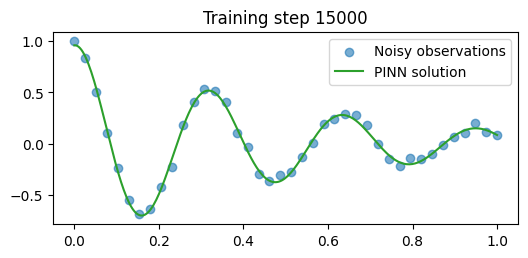

In [112]:
from torch import autograd  # Importar autograd

for i in range(epochs):
    optim.zero_grad()  # Resetear el gradiente

    # Calcular la pérdida de la ecuación diferencial
    u = pinn(t_physics)
    # Asumiendo que tienes una función para calcular dudt y d2udt2
    dudt = autograd.grad(u, t_physics, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2udt2 = autograd.grad(dudt, t_physics, grad_outputs=torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)

    # Calcular la pérdida en función de los datos
    u_pred = pinn(t_obs)
    loss2 = torch.mean((u_pred - u_obs) ** 2)

    # Calcular la pérdida total
    loss = loss1 + lambda1 * loss2

    # Backward pass
    loss.backward()

    # Actualizar los pesos
    optim.step()

    # Guardar el valor de mu
    mus.append(mu.item())

    # Visualización
    if i % 5000 == 0:
        u_test = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:,0], u_test[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()


### Estimacion de $\mu$

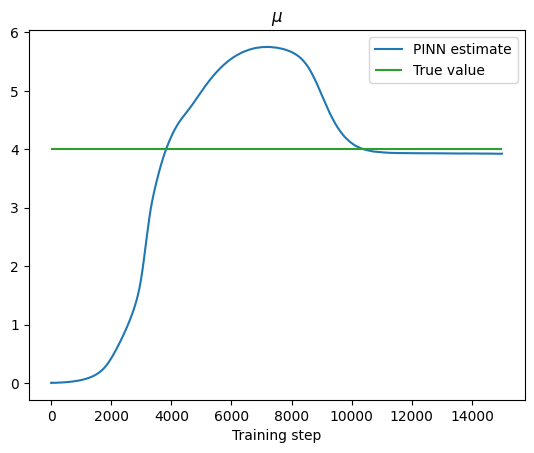

In [113]:
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

## cómo escala la PINN a oscilaciones de mayor frecuencia



La tarea final es investigar cómo escala la PINN a oscilaciones de mayor frecuencia y qué se puede hacer para mejorar su convergencia.

Específicamente, volvemos a simular la solución al oscilador armónico e incrementamos su frecuencia, $\omega_0$.


la PINN lucha para converger, incluso si el número de puntos de entrenamiento físico aumenta.

Este es un problema más difícil para la PINN de resolver, en parte debido al **sesgo espectral** de las redes neuronales, así como al hecho de que se requieren más puntos de entrenamiento.

#### Enfoque: formulación alternativa "ansatz"

Para acelerar la convergencia, una forma es **asumir algo** sobre la solución.

Por ejemplo, supongamos que sabemos por nuestra intuición física que la solución es de hecho sinusoidal.

Entonces, en lugar de tener la PINN aproximando directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

En su lugar, usamos la PINN como parte de un ansatz matemático de la solución, es decir

$$
\hat u(t; \theta, \alpha, \beta) = u_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t)~,
$$

donde $\alpha, \beta$ se tratan como parámetros adicionales aprendibles.

Comparando este ansatz con la solución exacta

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

Vemos que ahora la PINN solo necesita aprender la función exponencial, lo cual debería ser un problema mucho más fácil.

¡Una vez más, la autodiferenciación nos permite diferenciar fácilmente a través de este ansatz para entrenar la PINN!


### Puntos de Entrenamiento

In [121]:
# Definimos los parametros A y B para la Ansatz
a = torch.nn.Parameter(70*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# Definimos los puntos de borde
t_boundary = torch.tensor(0., dtype=torch.float).view(-1,1).requires_grad_(True)

# Definimos los puntos de entrenamiento sobre todo el dominio
t_physics = torch.linspace(0,1,40, dtype=torch.float).view(-1,1).requires_grad_(True)

# Parámetros del problema
d, w0 = 2, 80  # Las oscilaciones (w0) aumentaron
mu, k = 2 * d, w0 ** 2

# Solución Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

lambda1, lambda2 = 1e-1, 1e-4

### Hiperparámetros y Modelo

In [122]:
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)

mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
# Definir el optimizador incluyendo todos los parámetros aprendibles
optim = torch.optim.Adam(list(pinn.parameters()) + [a, b, mu], lr=1e-3)

### Entrenamiento

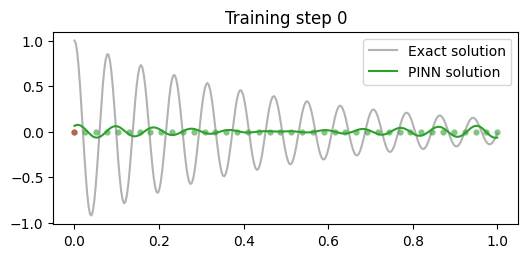

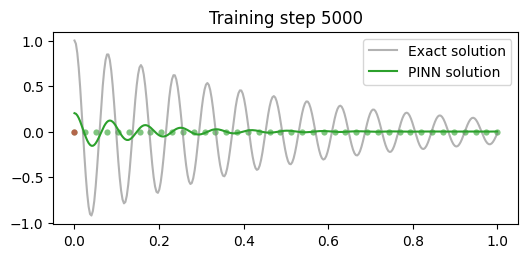

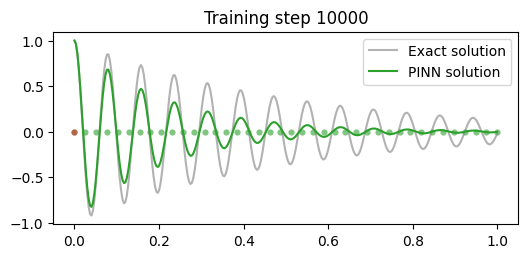

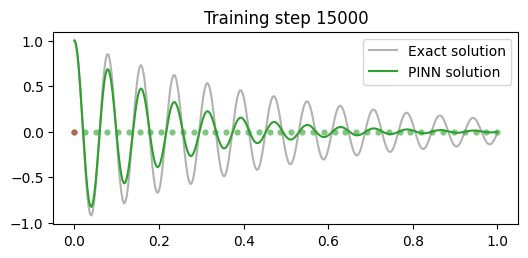

In [123]:
for i in range(15001):
    optim.zero_grad()  # Resetear el gradiente

    # Calcular la pérdida de la condición de borde
    u_boundary = pinn(t_boundary) * torch.sin(a * t_boundary + b)
    loss1 = (torch.squeeze(u_boundary) - 1)**2
    dudt = torch.autograd.grad(u_boundary, t_boundary, torch.ones_like(u_boundary), create_graph=True)[0] # calculamos la derivada
    loss2 = (torch.squeeze(dudt) - 0)**2

    # Calcular la pérdida de la ecuación diferencial
    u = pinn(t_physics) * torch.sin(a * t_physics + b)
    dudt = autograd.grad(u, t_physics, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2udt2 = autograd.grad(dudt, t_physics, grad_outputs=torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)

    # Calcular la pérdida total
    loss = loss1 + lambda1 * loss2 + lambda2 * loss3

    # Backward pass
    loss.backward()

    # Actualizar los pesos
    optim.step()

    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0:
        u = (pinn(t_test)*torch.sin(a*t_test+b)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()